In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import json
import os
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score
from mstream.mstream import Mstream

plt.style.use("ggplot")

<IPython.core.display.Javascript object>

In [3]:
DS_DIR = "data"
DS_NAMES = ["News", "News-T", "Tweets", "Tweets-T"]
DS_PATHS = [os.path.join(DS_DIR, ds_name) for ds_name in DS_NAMES]

<IPython.core.display.Javascript object>

In [4]:
def load_batches(ds_path, batch_size=int(2 ** 8)):
    with open(ds_path) as f:
        docs = []
        for line in f:
            parsed_line = json.loads(line)
            docs.append(parsed_line)
            if len(docs) == batch_size:
                yield docs
                docs = []
        if len(docs) > 0:
            yield docs

<IPython.core.display.Javascript object>

In [5]:
def transform(docs):
    return [{"id": doc["Id"], "word_list": doc["textCleaned"].split()} for doc in docs]

<IPython.core.display.Javascript object>

In [6]:
def calc_nmi(y, y_hat):
    return normalized_mutual_info_score(y, y_hat)

<IPython.core.display.Javascript object>

In [7]:
num_docs = sum([len(doc_batch) for doc_batch in load_batches(DS_PATHS[2])])
batch_size = math.ceil(num_docs / 16)
mstream = Mstream()
parsed_docs = next(load_batches(DS_PATHS[2], batch_size))
docs = transform(parsed_docs)
res = mstream.process(docs)

<IPython.core.display.Javascript object>

In [17]:
mstream.get_top_words(num_words_topic=2)

{0: {'sargent': 0.002144984277056998, 'pio': 0.002144984277056998},
 1: {'post': 0.003401472870777056, 'fox': 0.003401472870777056},
 2: {'haha': 0.0007022998615855612, 'set': 0.0007022998615855612},
 3: {'biting': 0.002174188373369362, 'read': 0.002174188373369362},
 4: {'find': 0.003326873385012923, 'chat': 0.003326873385012923},
 5: {'students': 0.0029619830908149724, 'rival': 0.0029619830908149724},
 6: {'shredded': 0.0035334476843910815, 'creamy': 0.0035334476843910815},
 7: {'area': 0.002707391441488803, 'lt': 0.002707391441488803},
 9: {'eye': 0.004927522365210737, 'moore': 0.004927522365210737},
 10: {'archive': 0.004087788228757388, 'working': 0.004087788228757388},
 11: {'align': 0.006252655861106046, 'elite': 0.006252655861106046},
 12: {'phd': 0.00520123213654497, 'american': 0.00520123213654497},
 13: {'france': 0.004192786778474319, 'dtn': 0.004192786778474319},
 14: {'attack': 0.008501155496863656, 'times': 0.008501155496863656},
 15: {'preview': 0.017460586540091538, 'g

<IPython.core.display.Javascript object>

Caculate the NMI for each batch

In [67]:
num_batches = 16
num_total_docs = sum([len(doc_batch) for doc_batch in load_batches(DS_PATHS[2])])
batch_size = math.ceil(num_total_docs / num_batches)
mstream = Mstream()
nmis = []
for parsed_docs in load_batches(DS_PATHS[2], batch_size):
    docs = transform(parsed_docs)
    nmi = normalized_mutual_info_score(
        [doc["clusterNo"] for doc in parsed_docs], mstream.process(docs)
    )
    nmis.append(nmi)

<IPython.core.display.Javascript object>

ValueError: x and y must have same first dimension, but have shapes (16,) and (10,)

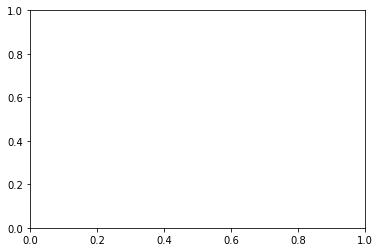

<IPython.core.display.Javascript object>

In [72]:
plt.plot(range(1, num_batches + 1), nmis)
plt.ylabel("NMI")
plt.xlabel("Batch number")
plt.title("NMI for each batch")
plt.show()

Calculate the NMI as a function of the number of iterations

In [29]:
num_batches = 16
max_num_iter = 11
num_iters = list(range(1, max_num_iter))
ds_nmis = []
for ds_path in DS_PATHS:
    num_total_docs = sum([len(batch) for batch in load_batches(ds_path)])
    batch_size = math.ceil(num_total_docs / num_batches)
    batch_size = 1
    nmis = []
    for num_iter in num_iters:
        mstream = Mstream(num_iter)
        y_hat = []
        y = []
        for parsed_docs in load_batches(ds_path, batch_size):
            y += [doc["clusterNo"] for doc in parsed_docs]
            y_hat += mstream.process(transform(parsed_docs))
        nmi = normalized_mutual_info_score(y, y_hat)
        nmis.append(nmi)
    ds_nmis.append(nmis)

<IPython.core.display.Javascript object>

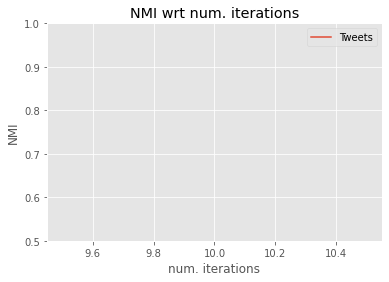

<IPython.core.display.Javascript object>

In [30]:
fig, ax = plt.subplots()
ax.set_title("NMI wrt num. iterations")
ax.set_xlabel("num. iterations")
ax.set_ylabel("NMI")
# ax.set_yticks(np.arange(0.5, 1.1, step=0.1))
ax.set_ylim(0.5, 1)
for i, ds_nmi in enumerate(ds_nmis):
    ax.plot(num_iters, ds_nmi, label=DS_NAMES[i])
ax.legend()